In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sys.path += ["../src"]
import causal_model
from matplotlib.pyplot import subplots as sbp
from importlib import reload
from glob import glob
import climact_utils as cu
import statsmodels.formula.api as smf

In [3]:
path_to_data = "/data/shared/xxx/climact/experiments/"

### Single Experiment

In [11]:
model_settings = {
    "lr": 0.01,
    "n_epochs": 200,
    "subreddit_class": "activism",
    "var_opinions": 0.1
                  }

In [4]:
df = causal_model.load_dataframe("activism")

In [16]:
sub_list = list(causal_model.scores.head(100).index) + known_subreddits

In [12]:
df = causal_model.load_dataframe("activism")
data, data_obs = causal_model.get_data(df, causal_model.scores)
subreddit_list = data[-1]
init_params_normal, init_params_multivariatenormal = causal_model.get_init_params(len(df))
init_params = causal_model.initialize_params(init_params_normal, init_params_multivariatenormal)
guide, svi = causal_model.get_guide(causal_model.model, model_settings, data, data_obs,
                                    init_params_normal, init_params_multivariatenormal, multivariate = True)


In [159]:
prior_samples, prior_predictions = causal_model.get_prior_samples(svi.guide, data, init_params, 10, 4)

In [1]:
guide, svi_results = causal_model.train(svi, guide, data, data_obs, model_settings, progress_bar = True, path = None, print_loss = True)

In [165]:
betas = causal_model.get_trained_beta(svi_results, data, data_obs, init_params_normal, init_params_multivariatenormal)

In [173]:
all_posteriors = causal_model.sample_posterior(guide, svi_results, data, num_samples = 10)

In [40]:
models_dict["activism"]["betas"]["beta_to_activation"]

opinion                                 0.64554864
norm_climate_long                              0.0
norm_climate_action_long                       0.0
norm_natural_disaster_long                     0.0
norm_climate_short                             0.0
norm_climate_action_short                      0.0
norm_natural_disaster_short                    0.0
interaction_short                          0.94884
avg_comments_per_thread_short                  0.0
n_submissions_author_week_short                0.0
n_active_days_author_week_short                0.0
n_comments_author_week_short                   0.0
n_different_subreddits_short                   0.0
log_avg_comments_per_thread_short              0.0
log_n_submissions_author_week_short            0.0
log_n_active_days_author_week_short            0.0
log_n_comments_author_week_short               0.0
log_n_different_subreddits_short               0.0
intercept                              -0.16626613
dtype: object

In [42]:
def plot_betas(betas):
    sns.set(font_scale = 0.7)
    fig, axes = sbp(ncols = 2, nrows = 2, figsize = (10,7))
    fig.subplots_adjust(wspace = 2)
    k = 0.1
    sns.heatmap(pd.DataFrame(pd.concat([betas["beta_to_opinions"]]).astype(float)), ax = axes[0,0], vmin = -k, vmax = k, cmap = "coolwarm", cbar = False, annot = True)
    sns.heatmap(pd.DataFrame(betas["beta_to_activation"].astype(float)), ax = axes[0,1], vmin = -k, vmax = k, cmap = "coolwarm", cbar = False, annot = True)
    sns.heatmap(pd.DataFrame(betas["beta_to_subreddit_LT"].astype(float)), ax = axes[1,0], vmin = -k, vmax = k, cmap = "coolwarm", cbar = True, annot = True)
    sns.heatmap(pd.DataFrame(betas["beta_to_subreddit_ST"].astype(float)), ax = axes[1,1], vmin = -k, vmax = k, cmap = "coolwarm", cbar = False, annot = True)

    axes[0,0].set_title("beta_to_opinions")
    axes[0,1].set_title("beta_to_activation")
    axes[1,0].set_title("beta_to_subreddit_LT")
    axes[1,1].set_title("beta_to_subreddit_ST")

    for ax in axes.ravel():
        ax.set_ylabel("")

    fig.show()

    sns.reset_orig()
    %matplotlib inline

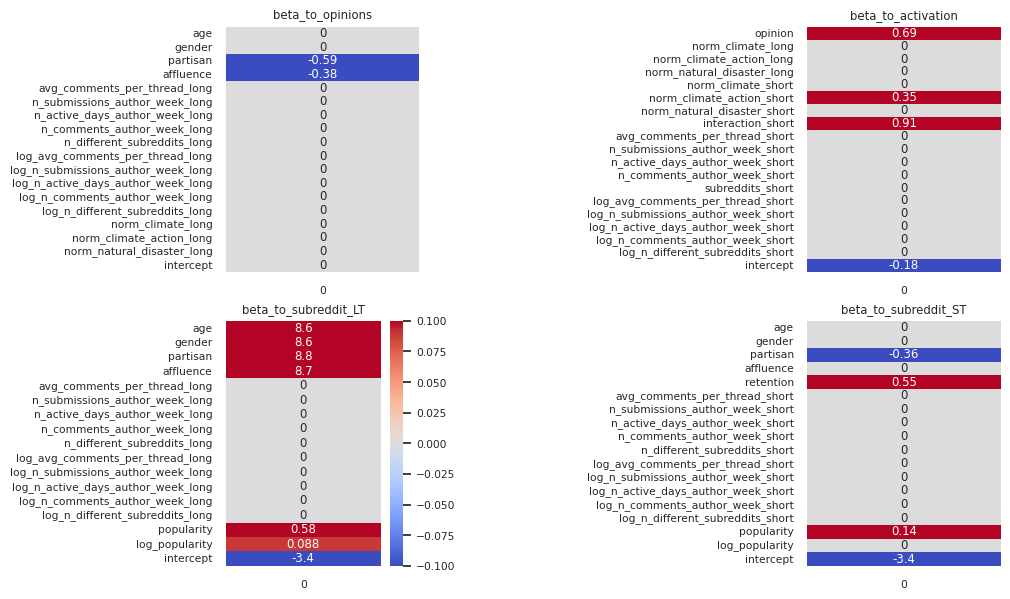

In [174]:
sns.set(font_scale = 0.7)
fig, axes = sbp(ncols = 2, nrows = 2, figsize = (10,7))
fig.subplots_adjust(wspace = 2)
k = 0.1
sns.heatmap(pd.DataFrame(pd.concat([betas["beta_to_opinions"]]).astype(float)), ax = axes[0,0], vmin = -k, vmax = k, cmap = "coolwarm", cbar = False, annot = True)
sns.heatmap(pd.DataFrame(betas["beta_to_activation"].astype(float)).rename(index = {u: u[12:] for u in df.columns if "n_different" in u}), ax = axes[0,1],
             vmin = -k, vmax = k, cmap = "coolwarm", cbar = False, annot = True)
sns.heatmap(pd.DataFrame(betas["beta_to_subreddit_LT"].astype(float)), ax = axes[1,0], vmin = -k, vmax = k, cmap = "coolwarm", cbar = True, annot = True)
sns.heatmap(pd.DataFrame(betas["beta_to_subreddit_ST"].astype(float)), ax = axes[1,1], vmin = -k, vmax = k, cmap = "coolwarm", cbar = False, annot = True)

axes[0,0].set_title("beta_to_opinions")
axes[0,1].set_title("beta_to_activation")
axes[1,0].set_title("beta_to_subreddit_LT")
axes[1,1].set_title("beta_to_subreddit_ST")

for ax in axes.ravel():
    ax.set_ylabel("")

fig.show()

sns.reset_orig()
%matplotlib inline

In [13]:
known_subreddits = "collapse, ChapoTrapHouse, chomsky, Anarchism, Anarcho_Capitalism, Anarchy101, environment, Patriots, Republican, climateskeptics, progun, tucker_carlson, AskThe_Donald, The_Donald, manga, AskReddit, funny, travel, ClashRoyale, baseball, yugioh".split(", ")
known_indices = [subreddit_list.index(u) for u in known_subreddits]

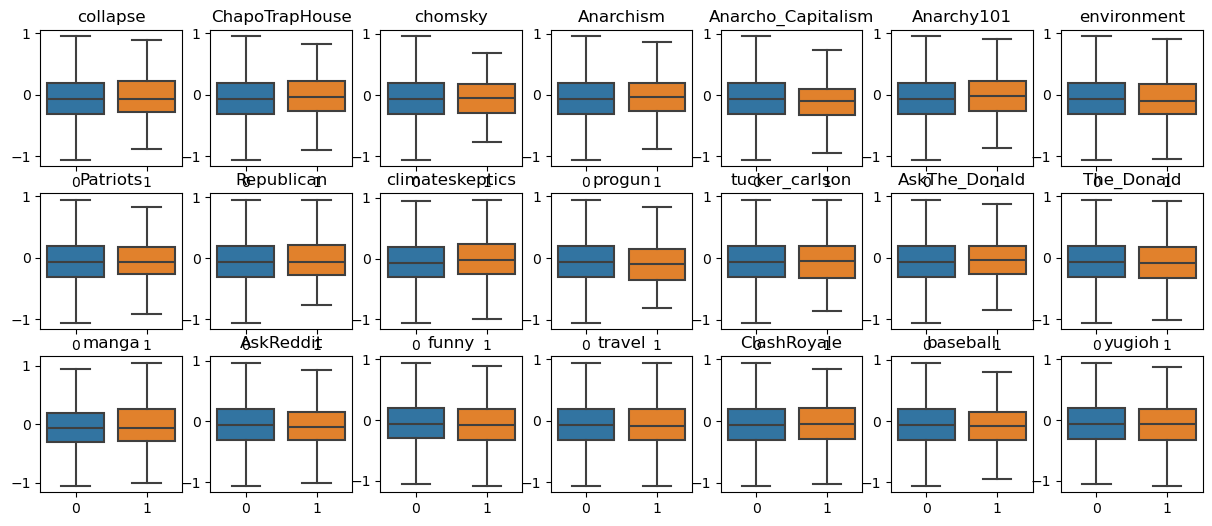

In [178]:
fig, axes = sbp(ncols = 7, nrows = 3, figsize = (15, 6))

for i in range(7):
    for j in range(3):
        k = i + j * 7
        axes[j,i].set_title(known_subreddits[k])
        sns.boxplot(x = np.array(all_posteriors["subreddit_ST"][0][:,known_indices[k]]), y = betas["opinions_users"], 
                    ax = axes[j,i], showfliers = False)

### Full experiments

In [14]:
def full_experiment(subreddit_class, n_epochs, lr, multivariate = True, date = "240903", id = "001"):
    model_settings = {
    "lr": lr,
    "n_epochs": n_epochs,
    "subreddit_class": "activism",
    "var_opinions": 0.1,
    "multivariate": multivariate,
                  }
    df = causal_model.load_dataframe(subreddit_class)
    data, data_obs = causal_model.get_data(df, causal_model.scores)
    
    init_params_normal, init_params_multivariatenormal = causal_model.get_init_params(len(df))
    init_params = causal_model.initialize_params(init_params_normal, init_params_multivariatenormal)
    guide, svi = causal_model.get_guide(causal_model.model, model_settings, data, data_obs,
                                        init_params_normal, init_params_multivariatenormal, multivariate = True)
    guide, svi_results, betas = causal_model.train(svi, guide, data, data_obs, model_settings, 
                                                   init_params_normal, init_params_multivariatenormal, progress_bar = True, early_stop = False,
                                                   path = path_to_data + f"{subreddit_class}_{date}_{id}.pkl", print_loss = True)


100%|██████████| 5000/5000 [09:14<00:00,  9.02it/s, init loss: 4183322.7500, avg. loss [4751-5000]: 1024377.5088]


1024532.7


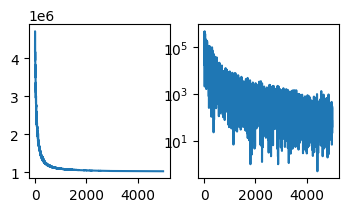

In [15]:
full_experiment("activism", 5000, 0.01, multivariate = True, date = "240930", id = "002")

In [2]:
# 2 hours 40min
for subreddit_class in ["activism", "skeptic", "action", "discussion"]:
    full_experiment(subreddit_class, 5000, 0.01, multivariate = True, id = "002")

### Analysis

In [4]:
models_dict = {u: causal_model.load_model(path_to_data + f"{u}_240905_002.pkl") for u in cu.subreddit_classes}

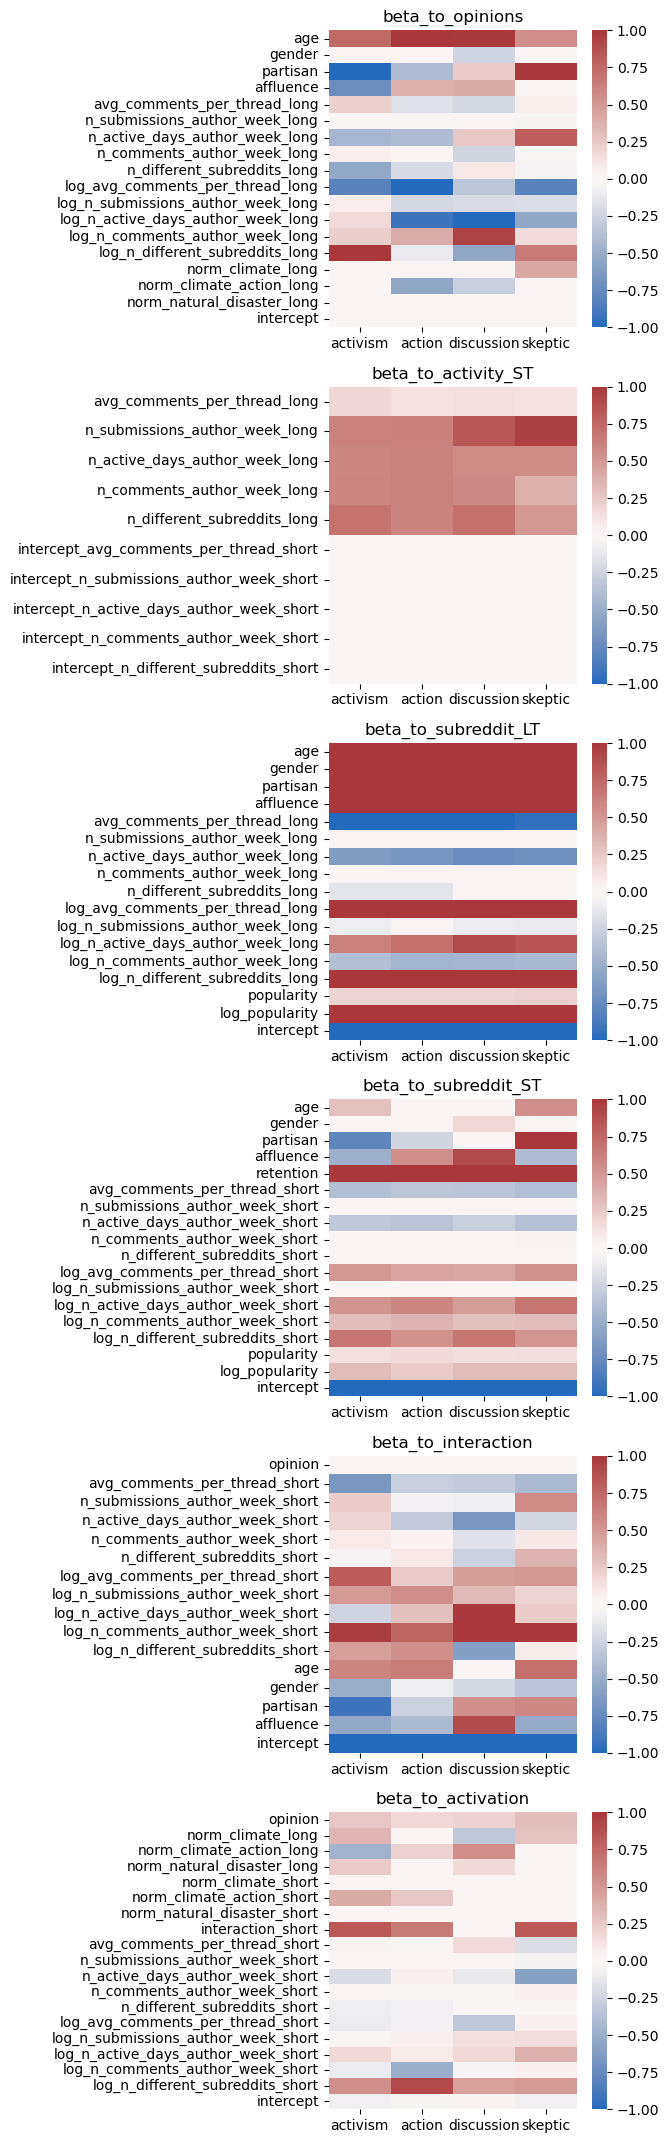

In [5]:
fig, axes = sbp(nrows = 6, figsize = (4, 27))
for i, u in enumerate(list(models_dict["action"]["betas"].keys())[:6]):
    sns.heatmap(pd.DataFrame({k: pd.DataFrame(models_dict[k]["betas"][u])[0] for k in cu.subreddit_classes}).astype(float),
                vmin = -1, vmax = 1, cmap = "vlag", ax = axes[i]
                )#.set_facecolor('white')

    axes[i].set_title(u)
fig.show()

In [7]:
list(models_dict["action"]["betas"].keys())[:1]

['beta_to_opinions']

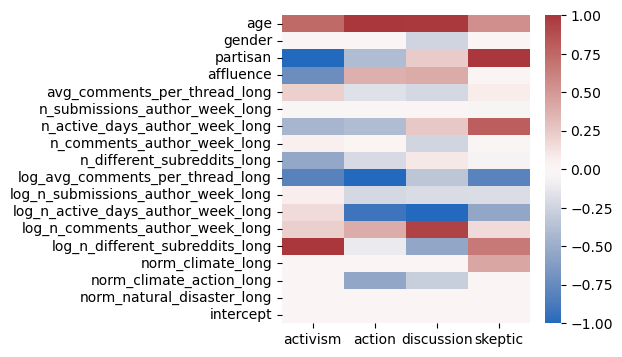

In [8]:
fig, axes = sbp(nrows = 1, figsize = (4, 4))
for i, u in enumerate(list(models_dict["action"]["betas"].keys())[:1]):
    sns.heatmap(pd.DataFrame({k: pd.DataFrame(models_dict[k]["betas"][u])[0] for k in cu.subreddit_classes}).astype(float),
                vmin = -1, vmax = 1, cmap = "vlag"
                )#.set_facecolor('white')

    axes.set_title("")
fig.show()

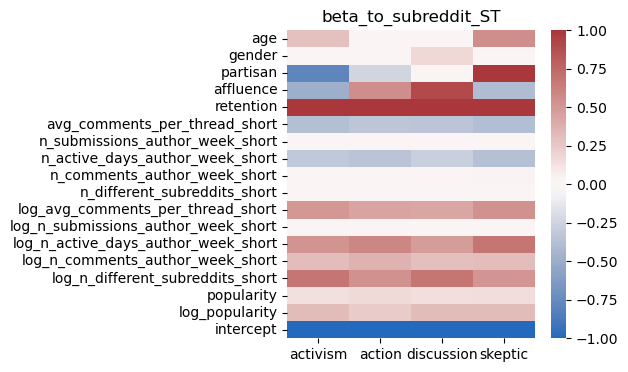

In [9]:
fig, axes = sbp(nrows = 1, figsize = (4, 4))
for i, u in enumerate(list(models_dict["action"]["betas"].keys())[3:4]):
    sns.heatmap(pd.DataFrame({k: pd.DataFrame(models_dict[k]["betas"][u])[0] for k in cu.subreddit_classes}).astype(float),
                vmin = -1, vmax = 1, cmap = "vlag"
                )#.set_facecolor('white')

    axes.set_title(u)
fig.show()

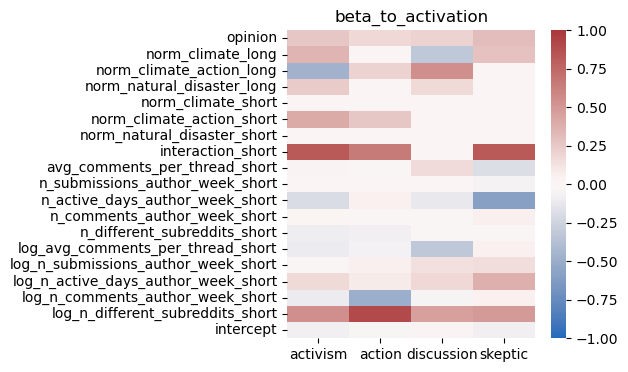

In [10]:
fig, axes = sbp(nrows = 1, figsize = (4, 4))
for i, u in enumerate(list(models_dict["action"]["betas"].keys())[5:6]):
    sns.heatmap(pd.DataFrame({k: pd.DataFrame(models_dict[k]["betas"][u])[0] for k in cu.subreddit_classes}).astype(float),
                vmin = -1, vmax = 1, cmap = "vlag"
                )#.set_facecolor('white')

    axes.set_title(u)
fig.show()

In [11]:
df_ = pd.DataFrame({k: pd.DataFrame(models_dict[k]["betas"][u])[0] for k in cu.subreddit_classes}).astype(float)#.iloc[[0,1,2,3,-4,-3,-2],:]
df_.rename(index = {u: u.replace("norm", "news").replace("long", "LT").replace("short", "ST") for u in df_.index}).iloc[:8,:]

,activism,action,discussion,skeptic
opinion,0.264545,0.172581,0.197502,0.311809
news_climate_LT,0.355623,0.000000,-0.324028,0.283948
news_climate_action_LT,-0.466112,0.204117,0.546379,0.000000
news_natural_disaster_LT,0.241648,0.000000,0.169974,0.000000
news_climate_ST,0.000000,0.000000,0.000000,0.000000
news_climate_action_ST,0.403320,0.257888,0.000000,0.000000
news_natural_disaster_ST,0.000000,0.000000,0.000000,0.000000
interaction_ST,0.821022,0.654147,0.000000,0.822800


In [106]:
all_posteriors = {subreddit_class: causal_model.sample_posterior(models_dict[subreddit_class]["guide"], 
                                                                 models_dict[subreddit_class]["params"], 
                                                                 causal_model.get_data(causal_model.load_dataframe(subreddit_class), causal_model.scores)[0], 
                                                                 num_samples = 10) for subreddit_class in cu.subreddit_classes}

In [173]:
all_posteriors[subreddit_class]["subreddit_ST"].reshape(-1, all_posteriors[subreddit_class]["subreddit_ST"].shape[-1])
# causal_model.jnp.resize(all_posteriors[subreddit_class]["subreddit_ST"], new_shape = (all_posteriors[subreddit_class]["subreddit_ST"].shape[0] * all_posteriors[subreddit_class]["subreddit_ST"].shape[1], all_posteriors[subreddit_class]["subreddit_ST"].shape[2]))

(77230, 826)

In [178]:
all_posteriors[subreddit_class]["opinions_pred"].reshape(-1).shape

(79640,)

In [180]:
subreddit_class = "activism"
k = 0
pred_sub_ST = {subreddit_class: pd.DataFrame(all_posteriors[subreddit_class]["subreddit_ST"].reshape(-1, all_posteriors[subreddit_class]["subreddit_ST"].shape[-1]), 
                                             columns = causal_model.subreddit_list).assign(opinion = all_posteriors[subreddit_class]["opinions_pred"].reshape(-1), 
                                                                                           activation = all_posteriors[subreddit_class]["activation"].reshape(-1)) for subreddit_class in cu.subreddit_classes}

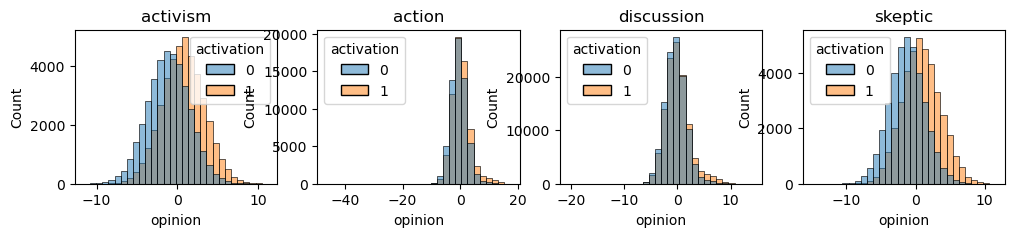

In [181]:
fig, axes = sbp(ncols = 4, figsize = (12,2))

for i,subreddit_class in enumerate(cu.subreddit_classes):
    sns.histplot(data = pred_sub_ST[subreddit_class], 
                x = "opinion", hue = "activation", bins = 30, ax = axes[i])
    axes[i].set_title(subreddit_class)


In [182]:
known_subreddits = "collapse, ChapoTrapHouse, chomsky, Anarchism, Anarcho_Capitalism, Anarchy101, environment, Patriots, Republican, climateskeptics, progun, tucker_carlson, AskThe_Donald, The_Donald, manga, AskReddit, funny, travel, ClashRoyale, baseball, yugioh".split(", ")
known_indices = [causal_model.subreddit_list.index(u) for u in known_subreddits]

In [183]:
def print_boxplots_subreddit_ST(pred_sub_ST, subreddit_class, known_subreddits):
    if  len(known_subreddits) % 3 != 0:
        print("len known subreddits must be divisible per 3")
    else:
        c = int(len(known_subreddits) / 3    )
        fig, axes = sbp(ncols = c, nrows = 3, figsize = (c * 2 + 1, 6), sharey = True)
        fig.suptitle(subreddit_class)

        for i in range(c):
            for j in range(3):
                k = i + j * c
                axes[j,i].set_title(known_subreddits[k])
                sns.boxplot(
                    data = pred_sub_ST[subreddit_class],
                    x = known_subreddits[k], 
                    y = "opinion", ax = axes[j,i], showfliers = False)
        fig.show()

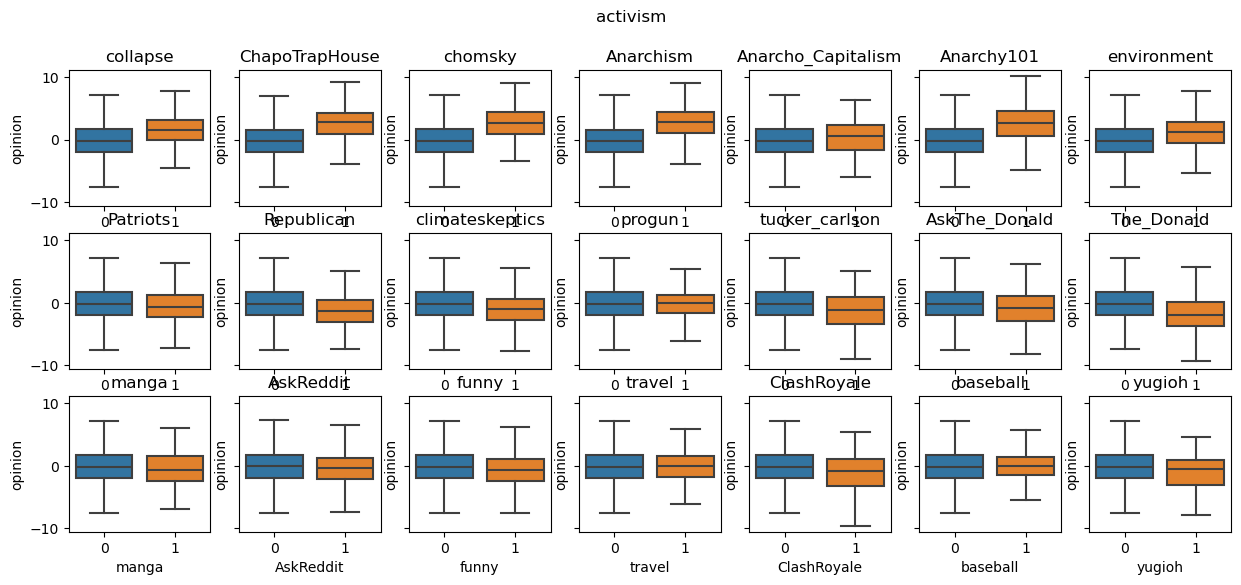

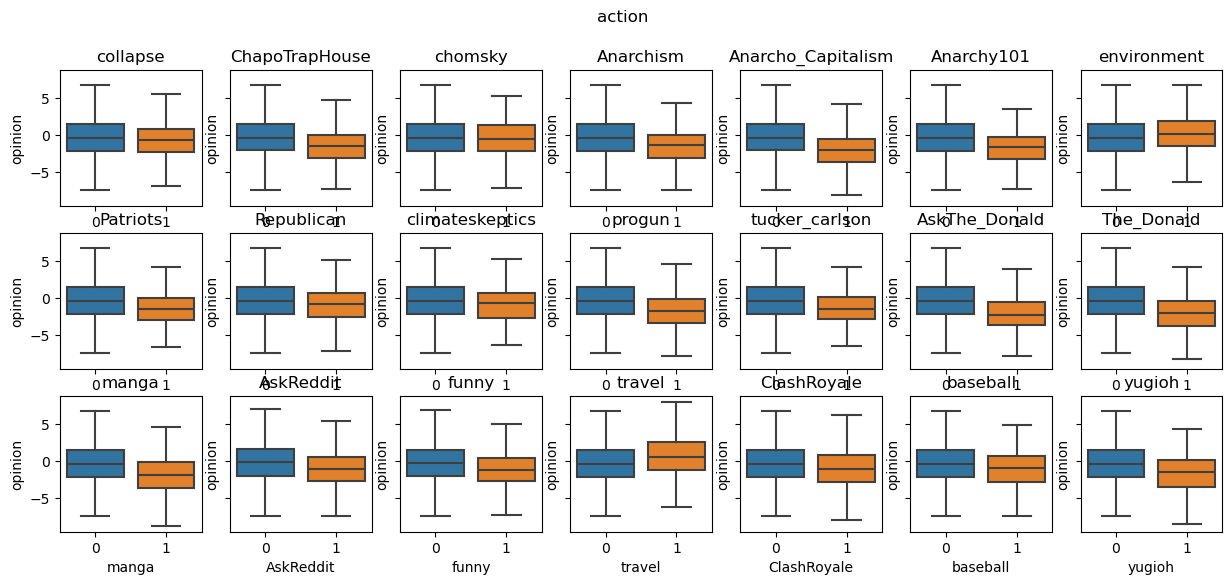

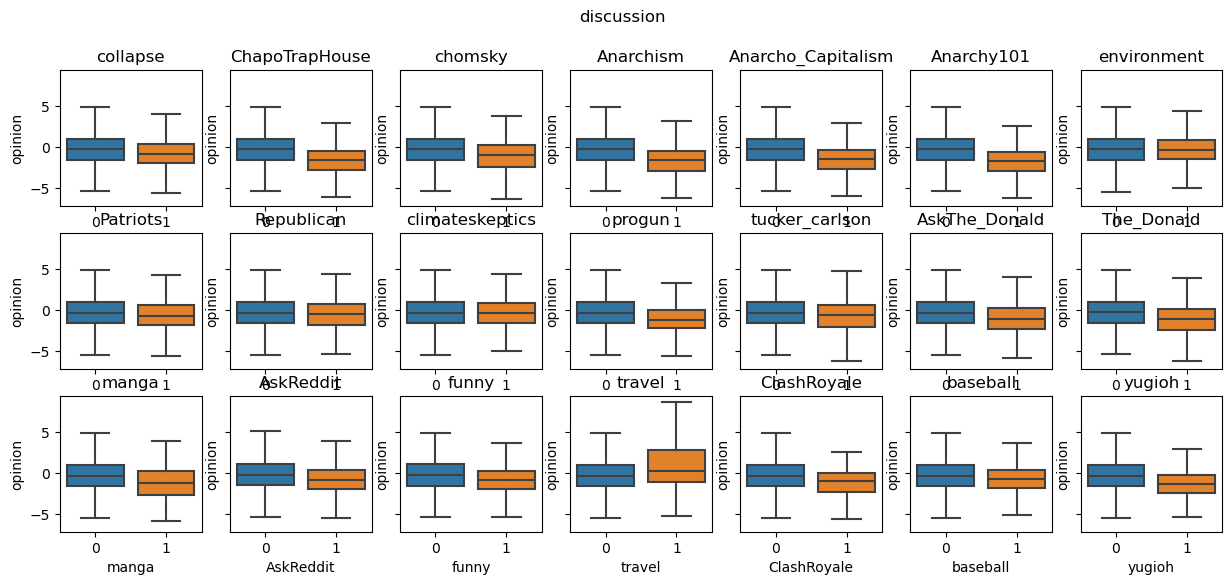

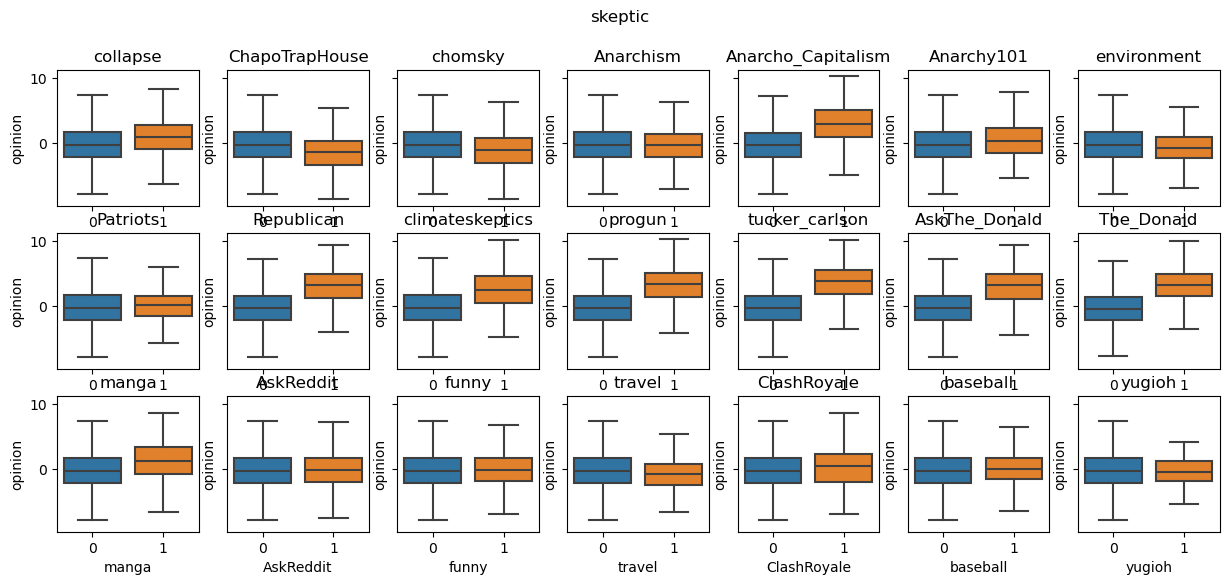

In [184]:
for subreddit_class in cu.subreddit_classes:
    print_boxplots_subreddit_ST(pred_sub_ST, subreddit_class, known_subreddits)

### Logistic Regression

In [21]:
def create_lr_df(df):
    data, data_obs = causal_model.get_data(df, causal_model.scores)

    subreddit_LT, activity_LT, log_activity_LT, news_LT, subreddit_ST, activity_ST, log_activity_ST, news_ST, interaction_ST, activation, sociodemo_subreddit, popularity_subreddits, log_popularity_subreddits, subreddit_list = data
    subreddit_LT_obs, activity_ST_obs, subreddit_ST_obs, interaction_ST_obs, activation_obs = data_obs

    df_lr = pd.concat([pd.DataFrame(subreddit_LT @ sociodemo_subreddit, columns = [f"{u}_subreddit_LT" for u in causal_model.scores.columns]),
        pd.DataFrame(subreddit_ST @ sociodemo_subreddit, columns = [f"{u}_subreddit_ST" for u in causal_model.scores.columns]),
        pd.DataFrame(activity_LT, columns = cu.features_join["control_long"]),
        pd.DataFrame(activity_ST, columns = cu.features_join["control_short"]),
        pd.DataFrame(log_activity_LT, columns = ["log_" + u for u in cu.features_join["control_long"]]),
        pd.DataFrame(log_activity_ST, columns = ["log_" + u for u in cu.features_join["control_short"]]),
        pd.DataFrame(news_LT, columns = cu.features_join["norm_news_long"]),
        pd.DataFrame(news_ST, columns = cu.features_join["norm_news_short"]),
        pd.DataFrame(interaction_ST, columns = ["interaction"]),
        pd.DataFrame(activation[:,0], columns = ["activation"])], axis = 1)
    return df_lr



def full_log_reg(subreddit_class):
    df = causal_model.load_dataframe(subreddit_class)
    df_lr = create_lr_df(df)
    covariates = " + ".join([u for u in df_lr.drop(columns = ["activation"]).columns])
    model = smf.logit(f"activation ~ {covariates}", data = df_lr + 0.).fit()
    predictions = model.predict((df_lr + 0.).drop(columns = "activation"))    
    return model, predictions, df_lr

def save_lr(model, predictions, df_lr, id):
    pd.DataFrame({"pred":predictions, "actual": df_lr["activation"]}).to_csv(path_to_data + f"pred_{id}.csv")
    model.summary2().tables[1].rename(columns = {"P>|z|": "p"}).to_csv(path_to_data + f"coef_table_{id}.csv")

def load_lr(id):
    predictions = pd.read_csv(path_to_data + f"pred_{id}.csv", index_col = 0)
    coefs = pd.read_csv(path_to_data + f"coef_table_{id}.csv", index_col=0).assign(coef = lambda x: x["Coef."] * (x["p"] < 0.05))
    return predictions, coefs

In [258]:
for subreddit_class in cu.subreddit_classes:
    print(subreddit_class)
    model, predictions, df_lr = full_log_reg(subreddit_class)
    save_lr(model, predictions, df_lr, id = f"lr_{subreddit_class}_240904_002")

activism
Optimization terminated successfully.
         Current function value: 0.587471
         Iterations 6
action
Optimization terminated successfully.
         Current function value: 0.619898
         Iterations 7
discussion
Optimization terminated successfully.
         Current function value: 0.644701
         Iterations 6
skeptic
Optimization terminated successfully.
         Current function value: 0.576394
         Iterations 7


In [22]:
experiments_lr = {u: load_lr(f"lr_{u}_240904_002") for u in cu.subreddit_classes}

In [26]:
df_all_coefs_lr = pd.concat([experiments_lr[u][1].rename(columns = {"coef": u})[u] for u in experiments_lr], axis = 1)

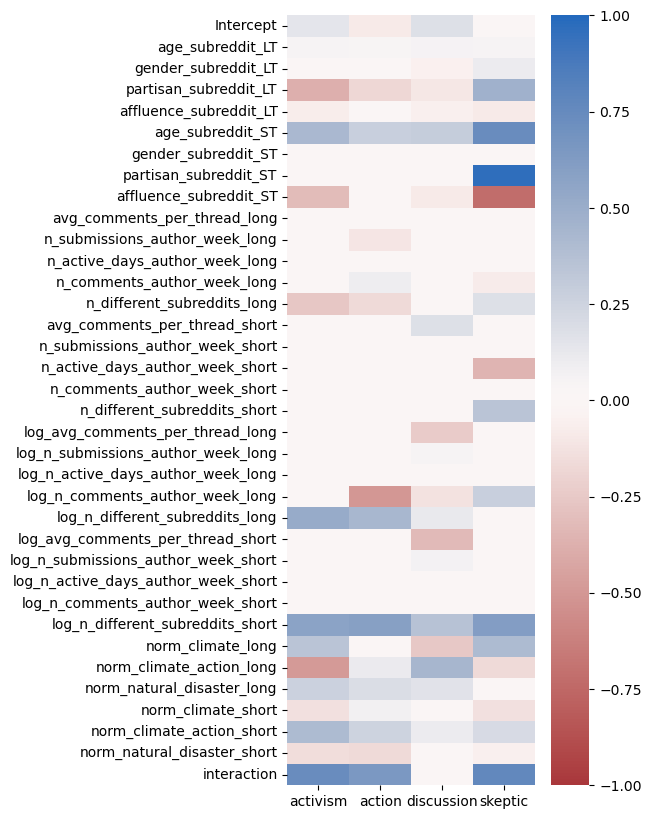

In [27]:
fig, axes = sbp(figsize = (4,10))

sns.heatmap(df_all_coefs_lr,
            vmin = -1, vmax = 1, cmap = "vlag_r",
            )#.set_facecolor('white')


fig.show()

In [38]:
{u: experiments_lr[u][0].apply(lambda x: x.round() + 0.).apply(lambda x: x["pred"] == x["actual"], axis = 1).mean() for u in cu.subreddit_classes}

{'activism': 0.6898543445504771,
 'action': 0.6594469309462916,
 'discussion': 0.6302613118204139,
 'skeptic': 0.6988217014113687}

### Dates

In [168]:
end_date = pd.to_datetime("20220430", format = "%Y%m%d")

In [169]:
df_nonactive = pd.concat([causal_model.load_dataframe(subreddit_class).query("~activation") for subreddit_class in cu.subreddit_classes])

In [ ]:
df_active = causal_model.load_dataframe("skeptic").query("activation")

In [170]:
df_nonactive_sample = (df_nonactive.reset_index()
                       .assign(date = lambda x: [pd.to_datetime(u + "_0", format = "%Y_%W_%w") for u in x["week_year"]])
                       .query("date < @end_date").set_index(["author", "week_year"]).drop(columns = ["date"])
                       .sample(len(df_active), replace=False, random_state = 10))

In [171]:
df = pd.concat([df_active, df_nonactive_sample])

In [172]:
df_date = df.reset_index().assign(date = lambda x: [pd.to_datetime(u + "_0", format = "%Y_%W_%w") for u in x["week_year"]])

<Axes: xlabel='date'>

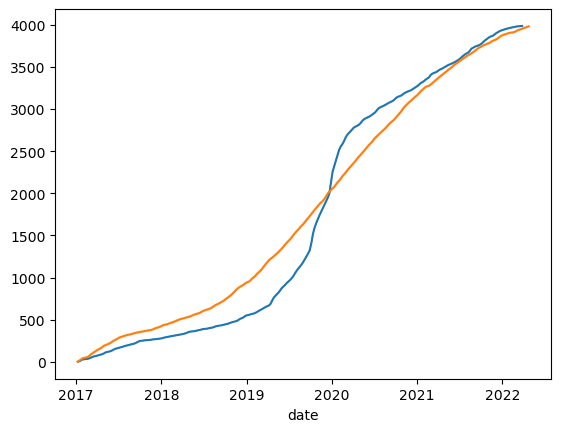

In [173]:
sns.lineplot(x = df_date.query("activation").sort_values("date")["date"], y = np.arange(len(df_date.query("activation"))))
sns.lineplot(x = df_date.query("~activation").sort_values("date")["date"], y = np.arange(len(df_date.query("~activation"))))

<Axes: xlabel='date', ylabel='norm_climate_action_long'>

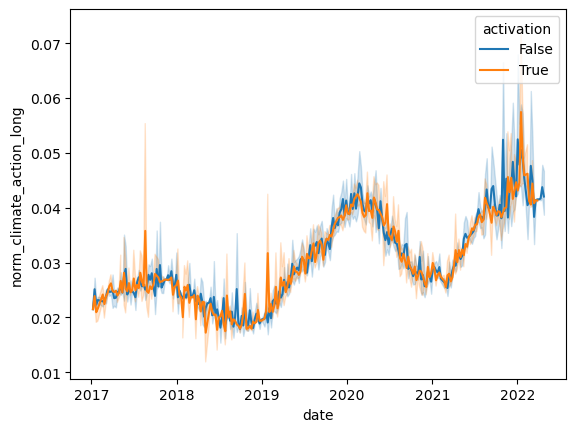

In [174]:
sns.lineplot(data = df_date, x = "date", y = "norm_climate_action_long", hue = "activation")

In [185]:
pd.read_csv(cu.data_path + f"authors_featurs_df_old/{subreddit_class}.csv.gz", 
                        compression = "gzip", index_col = [0,1])

,,activation,duration,norm_climate_short,norm_climate_action_short,norm_natural_disaster_short,norm_climate_medium,norm_climate_action_medium,norm_natural_disaster_medium,norm_climate_long,norm_climate_action_long,...,relderscrollsonline_short_long_ratio,rMonsterHunter_short_long_ratio,rRedditSessions_short_long_ratio,rDamnthatsinteresting_short_long_ratio,rbuildapcsales_short_long_ratio,rTrueChristian_short_long_ratio,rImpeach_Trump_short_long_ratio,rLateStageCapitalism_short_long_ratio,rLiverpoolFC_short_long_ratio,rConservative_short_long_ratio
author,week_year,,,,,,,,,,,,,,,,,,,,,
-4LPH40M3G4-,2019_42,True,6,0.132147,0.065407,0.218323,0.117004,0.049470,0.098626,0.104151,0.039445,...,False,False,False,False,False,False,False,False,False,False
-horses,2018_50,True,1,0.224088,0.050882,0.121980,0.153901,0.078598,0.227769,0.127212,0.037098,...,False,False,False,False,False,False,False,False,False,False
1-123581385321-1,2019_04,True,4,0.095691,0.033816,0.175306,0.108418,0.031591,0.139121,0.089186,0.031719,...,False,False,False,False,False,False,False,False,False,False
1Bam18,2021_33,True,6,0.088686,0.038637,0.144441,0.077309,0.023565,0.097155,0.097810,0.043068,...,False,False,False,False,False,False,False,False,False,False
200ftsearise,2018_46,True,3,0.155985,0.088193,0.143979,0.156658,0.057269,0.101972,0.124328,0.035556,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TeenieLinguine,2020_11,False,7,0.074378,0.034599,0.086766,0.087158,0.032195,0.093224,0.104088,0.041018,...,False,False,False,False,False,False,False,False,False,False
HockeyBalboa,2019_02,False,7,0.104369,0.036855,0.134979,0.083749,0.024022,0.133418,0.087612,0.020306,...,False,False,False,False,False,False,False,False,False,False
LittleOwl12,2018_11,False,7,0.075887,0.018827,0.106474,0.083064,0.015555,0.124717,0.089994,0.023433,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_active_users = {subreddit_class: pd.read_csv(cu.data_path + f"authors_featurs_df_old/{subreddit_class}.csv.gz", 
                        compression = "gzip", index_col = [0,1]).query("activation") for subreddit_class in cu.subreddit_classes}

In [242]:
small_subs = ["CFBOffTopic", "PictureGame", "SCJerk", "Torontobluejays", "cowboys", "psg", 'BABYMETAL', 'Random_Acts_Of_Amazon']
subreddits_cols = [f"r{u}_{p}" for u in subreddit_list for p in ["short", "medium", "long"] if u not in small_subs]
cols = [u for k in  ['control_short',
 'control_medium',
 'control_long',
 'interaction_short',
 'interaction_medium',
 'interaction_long',
 'norm_news_short',
 'norm_news_medium',
 'norm_news_long',]
 for u in cu.features_join[k]] + subreddits_cols + ["activation"]

In [243]:
non_active_users = pd.concat([pd.read_csv(cu.data_path + f"authors_featurs_df_old/{subreddit_class}.csv.gz", 
                        compression = "gzip", index_col = [0,1]).query("~activation")[cols] for subreddit_class in cu.subreddit_classes])

In [244]:
non_active_users_restrict = (non_active_users.reset_index()
                       .assign(date = lambda x: [pd.to_datetime(u + "_0", format = "%Y_%W_%w") for u in x["week_year"]])
                       .query("date < @end_date").set_index(["author", "week_year"]).drop(columns = ["date"])
                       )

In [252]:
for j, subreddit_class in enumerate(cu.subreddit_classes):
    df = pd.concat([df_active_users[subreddit_class][cols], 
              non_active_users_restrict.sample(len(df_active_users[subreddit_class]), 
                                               replace=False, random_state = j)])
    df.to_csv(cu.data_path + f"authors_featurs_df/{subreddit_class}.csv.gz", 
              compression = "gzip")




In [257]:
for subreddit_class in cu.subreddit_classes:
    df = (pd.read_csv(cu.data_path + f"authors_featurs_df_old/{subreddit_class}.csv.gz", 
                        compression = "gzip", index_col = [0,1])
                        .reset_index()
                        .assign(date = lambda x: [pd.to_datetime(u + "_0", format = "%Y_%W_%w") for u in x["week_year"]])
                        .query("date < @end_date").set_index(["author", "week_year"]).drop(columns = ["date"]))
    df.to_csv(cu.data_path + f"authors_featurs_df/{subreddit_class}.csv.gz", 
              compression = "gzip")